# Single variable networks

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 

from numpy.lib.stride_tricks import sliding_window_view

import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [388]:
df = pd.read_csv('GOOGL.csv')
df.Date = pd.to_numeric(pd.to_datetime(df.Date, format='%Y-%m-%d'))
df.pop('Adj Close')

0         50.220219
1         54.209209
2         54.754753
3         52.487488
4         53.053055
           ...     
4426    2722.510010
4427    2722.030029
4428    2797.360107
4429    2765.510010
4430    2831.439941
Name: Adj Close, Length: 4431, dtype: float64

In [389]:
df.describe()

,Date,Open,High,Low,Close,Volume
count,4.431000e+03,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,1.370505e+18,693.087345,699.735595,686.078751,693.097367,6.444992e+06
std,1.603781e+17,645.118799,651.331215,638.579488,645.187806,7.690351e+06
min,1.092874e+18,49.644646,50.920921,48.028027,50.055054,4.656000e+05
25%,1.231762e+18,248.558563,250.853355,245.813309,248.415916,1.695600e+06
50%,1.370563e+18,434.924927,437.887878,432.687683,435.330322,3.778418e+06
75%,1.509192e+18,1007.364990,1020.649994,997.274994,1007.790008,8.002390e+06
max,1.648080e+18,3025.000000,3030.929932,2977.979980,2996.770020,8.215117e+07


## Setup

In [335]:
def prepare_data_partial(data, scaler, window_size=50, train=True):
    data = np.reshape(data, (-1,1))
    scaled_data = scaler.fit_transform(data) if train else scaler.transform(data)
    input_data = sliding_window_view((scaled_data).ravel(), window_size, axis=0)[:-1]
    input_data = np.reshape(input_data, (input_data.shape[0], input_data.shape[1],1))
    output_data = scaled_data.ravel()[window_size:]
    output_data = np.reshape(output_data, (-1,1))
    return (input_data, output_data)
    
def prepare_data(data, scaler, split=0.9, window_size=50):
    train_size = int(0.9*len(data))
    
    #scaler.fit(data)
    
    train = data[:train_size]
    test = data[train_size:]
    
    preped_train = prepare_data_partial(train, scaler, window_size, True)
    preped_test = prepare_data_partial(test, scaler, window_size, True)
    return (preped_train, preped_test)

In [336]:
scaler = MinMaxScaler((-1,1))
data = np.array(df.Open).reshape(-1,1)
((X_train, y_train), (X_test, y_test)) = prepare_data(data, scaler)

## SimpleRNN

### Rekomendacija sa interneta

Mreza je data kao primer mreze koja funkcionise dobro na stocks problemima.

In [291]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-6, momentum=0.9, nesterov=True),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_40 (SimpleRNN)   (None, 50, 50)            2600      
                                                                 
 dropout_10 (Dropout)        (None, 50, 50)            0         
                                                                 
 simple_rnn_41 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_42 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_43 (SimpleRNN)   (None, 50)                5050      
                                                                 
 batch_normalization_10 (Ba  (None, 50)                200       
 tchNormalization)                                               
                                                     

Best bal loss: 0.030584441497921944


<Axes: >

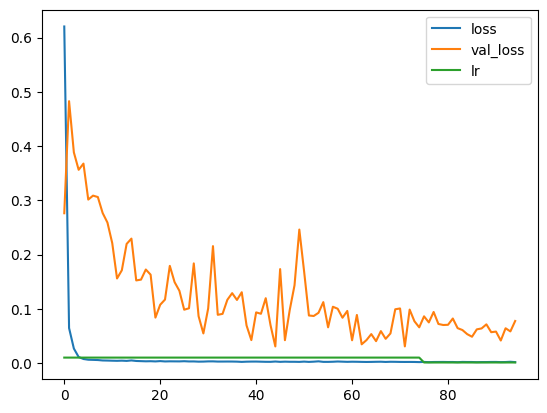

In [314]:
print(f"Best bal loss: {min(history.history['val_loss'])}")
pd.DataFrame(history.history).plot()

<Axes: >

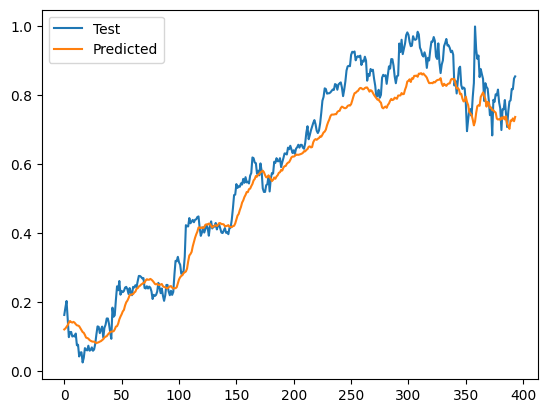

In [299]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
sns.lineplot(res, dashes=False)

Mreza se previse overfittuje, tkd se pojednostavljuje.

### 4 SimpleRNN sloja

In [323]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_80 (SimpleRNN)   (None, 50, 50)            2600      
                                                                 
 simple_rnn_81 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_82 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_83 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 17801 (69.54 KB)
Trainable params: 17801 (69.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25

Best bal loss: 0.010839550755918026


<Axes: >

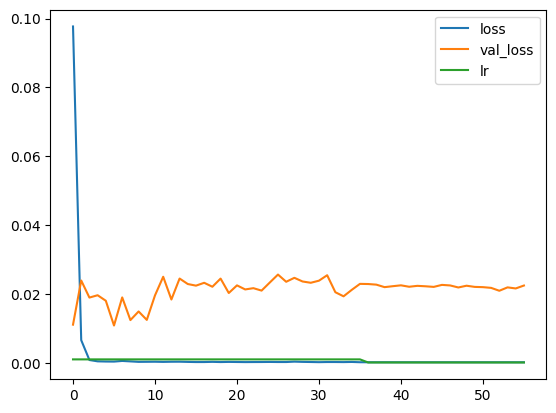

In [324]:
print(f"Best val loss: {min(history.history['val_loss'])}")
pd.DataFrame(history.history).plot()

13/13 [==============================] - 0s 13ms/step


<Axes: >

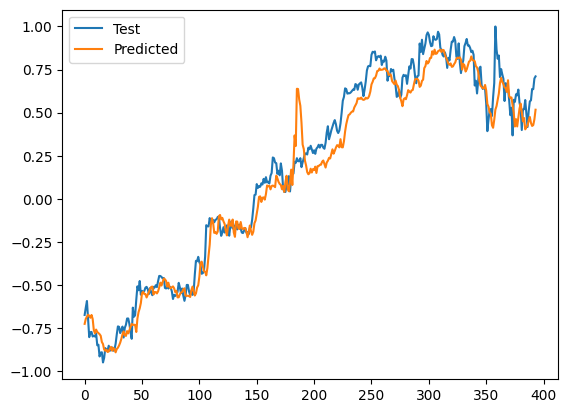

In [325]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
sns.lineplot(res, dashes=False)

### 3 SimpleRNN sloja

In [339]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_91 (SimpleRNN)   (None, 50, 50)            2600      
                                                                 
 simple_rnn_92 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_93 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12751 (49.81 KB)
Trainable params: 12751 (49.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 4s 71ms/step - loss: 0.0254 - val_loss: 0.0204 - lr: 0.0010
Epoch 2/300
25/25 [=================

13/13 [==============================] - 0s 10ms/step


<Axes: >

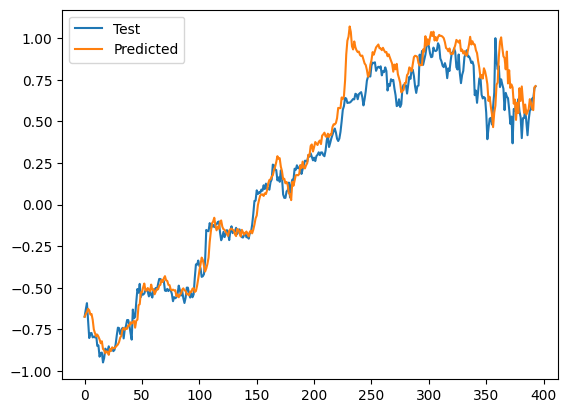

In [340]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
sns.lineplot(res, dashes=False)

### 1 SimpleRNN sloj

In [363]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_99 (SimpleRNN)   (None, 50)                2600      
                                                                 
 dense_34 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 2s 30ms/step - loss: 0.0450 - val_loss: 0.0063 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0074 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 18ms/step - loss: 5.2030e-04 - val_loss: 0.0074 - lr: 0.0010
Epoch 4/300
25/25 [==============================] - 0s 16ms/step - loss

13/13 [==============================] - 0s 5ms/step


<Axes: >

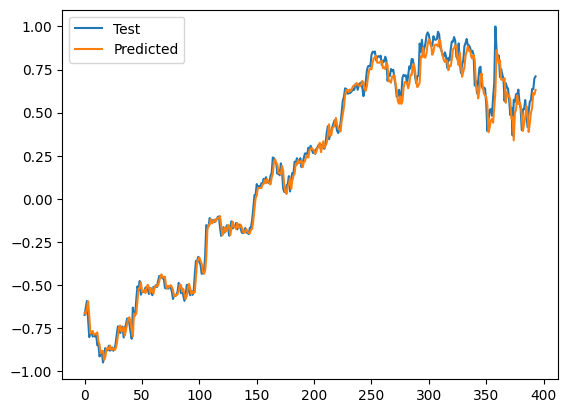

In [364]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
sns.lineplot(res, dashes=False)

Best val loss: 0.001466692890971899


<Axes: >

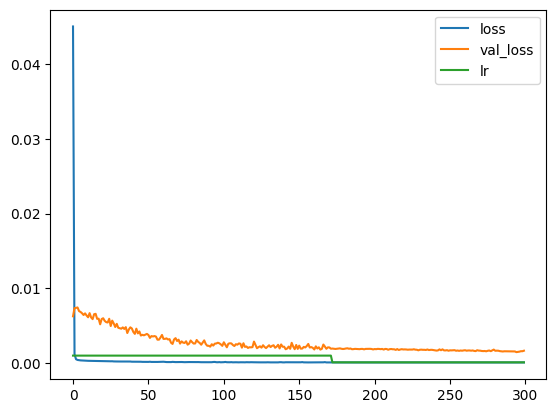

In [365]:
print(f"Best val loss: {min(history.history['val_loss'])}")
pd.DataFrame(history.history).plot()

Daje najbolje rezultate pa se cuva za kasnije

In [369]:
model_srnn = model
history_srnn = history

## LSTM

In [370]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 600
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/600
25/25 [==============================] - 2s 18ms/step - loss: 0.0599 - val_loss: 0.0876 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0571 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0390 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 8ms/step - loss: 5.6

13/13 [==============================] - 0s 2ms/step


<Axes: >

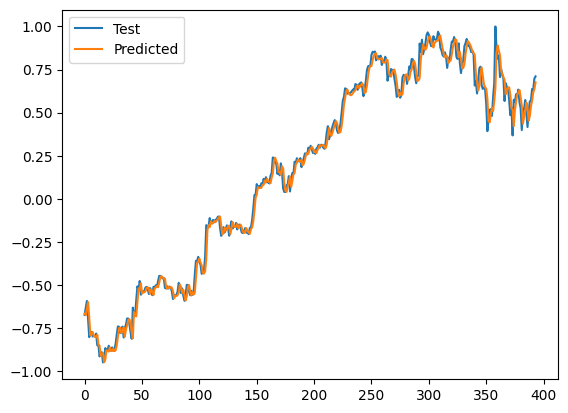

In [372]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
sns.lineplot(res, dashes=False)

Best val loss: 0.0007996639469638467


<Axes: >

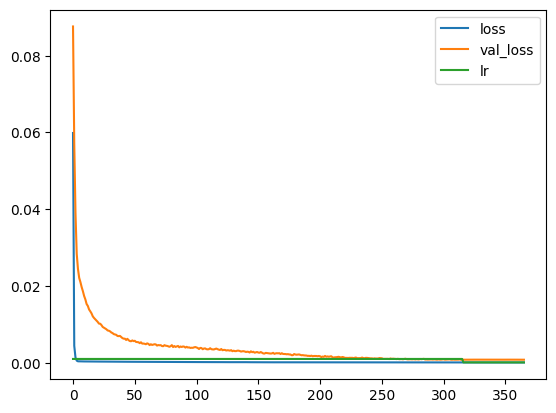

In [373]:
print(f"Best val loss: {min(history.history['val_loss'])}")
pd.DataFrame(history.history).plot()

In [374]:
model_lstm = model
history_lstm = history

### 2 LSTM sloja

In [357]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 600
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/600
25/25 [==============================] - 5s 38ms/step - loss: 0.0580 - val_loss: 0.0846 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0493 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0

13/13 [==============================] - 1s 2ms/step


<Axes: >

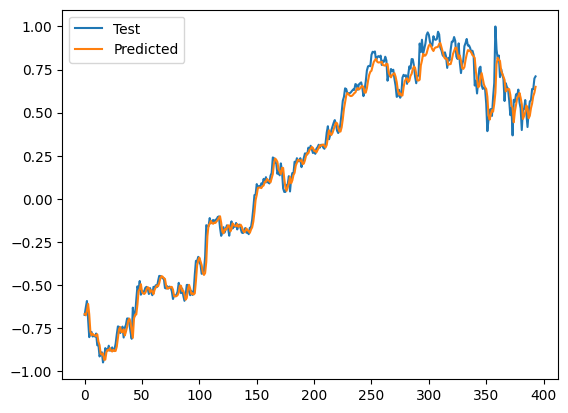

In [358]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
sns.lineplot(res, dashes=False)

## GRU

In [355]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])

epochs = 600
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/600
25/25 [==============================] - 2s 16ms/step - loss: 0.0546 - val_loss: 0.0829 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0464 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0191 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 5ms/step - loss: 5.5147e-04 - val_loss: 0.0065 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 5ms/step - loss: 1.8834e-04 - val_loss: 0.0031 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 5ms/step - loss: 1.5226e-04 - val_loss: 0.0026 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 5ms/step - loss: 1.4974e-04 - val_loss: 0.0027 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 6ms/step - loss: 1.4680e-04 - val_loss: 0.0027 - lr: 0.0010
Epoch 9/600
25/25 [==============================] - 0s 4ms/step - loss: 1.4438e-04

13/13 [==============================] - 0s 2ms/step


<Axes: >

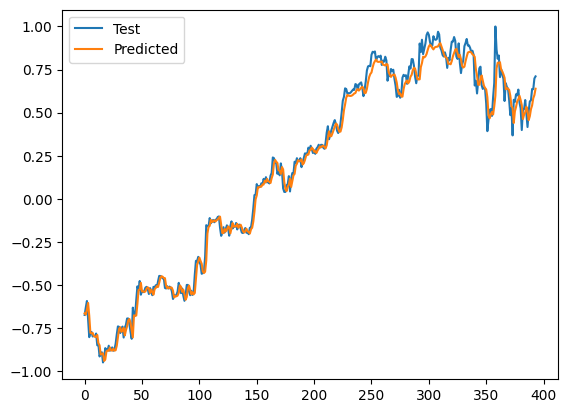

In [356]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
sns.lineplot(res, dashes=False)

### 2 GRU sloja

In [375]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])

epochs = 600
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/600
25/25 [==============================] - 3s 27ms/step - loss: 0.0322 - val_loss: 0.0384 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0048 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 7ms/step - loss: 3.2158e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 8ms/step - loss: 1.9844e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 8ms/step - loss: 1.8487e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 8ms/step - loss: 1.8013e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 8ms/step - loss: 1.7651e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 8ms/step - loss: 1.7265e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 9/600
25/25 [==============================] - 0s 8ms/step - loss: 1.6998

13/13 [==============================] - 1s 2ms/step


<Axes: >

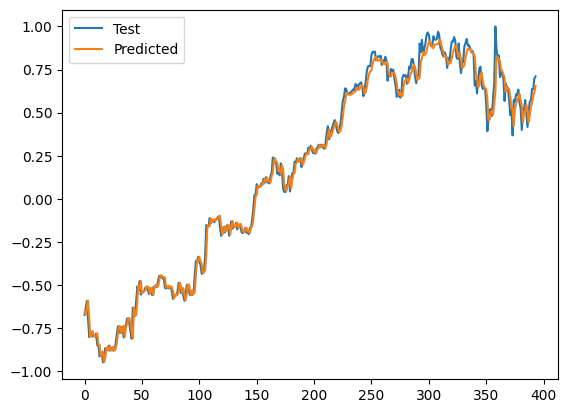

In [376]:
y_pred = model.predict(X_test)
res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
sns.lineplot(res, dashes=False)

Best val loss: 0.0008953898795880377


<Axes: >

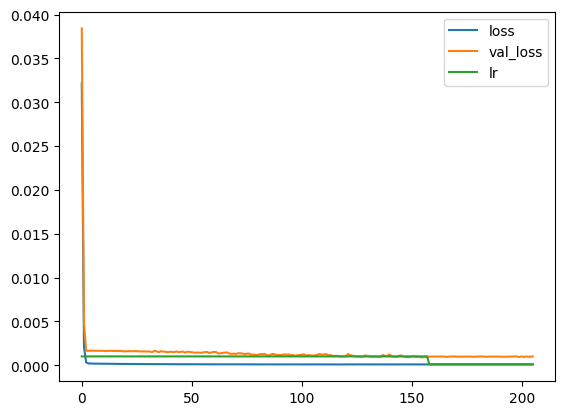

In [377]:
print(f"Best val loss: {min(history.history['val_loss'])}")
pd.DataFrame(history.history).plot()

In [378]:
model_gru = model
history_gru = history

## Poredjenje

In [387]:
srnn = pd.DataFrame(history_srnn.history)
srnn['type'] = 'SimpleRNN'
gru = pd.DataFrame(history_gru.history)
gru['type'] = 'GRU'
lstm = pd.DataFrame(history_lstm.history)
lstm['type'] = 'LSTM'
history_df = pd.concat([srnn, gru, lstm])

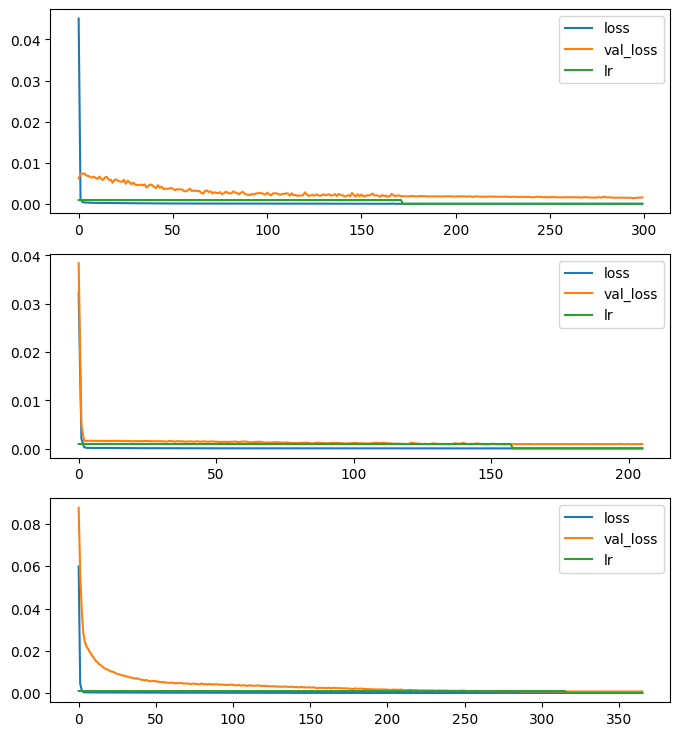

In [395]:
fig = plt.figure(figsize=(8,9))
axs = fig.subplots(nrows=3)
for i, history in enumerate([srnn, gru, lstm]):
    history.plot(ax=axs[i])

In [398]:
history_df.groupby('type').min().sort_values(by='val_loss')

,loss,val_loss,lr
type,,,
LSTM,0.000082,0.000800,0.0001
GRU,0.000081,0.000895,0.0001
SimpleRNN,0.000082,0.001467,0.0001


In [412]:
mae_res = []
mae_res.append(1)

In [418]:
y_test.shape, y_pred.shape

((394, 1), (394, 1))

In [423]:
y_pred = model_srnn.predict(X_test)
keras.losses.MeanAbsoluteError()(y_test, y_pred).numpy()

13/13 [==============================] - 0s 4ms/step


0.04095243

In [426]:
mae_res = []
mse_res = []
rmse_res = []
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()
rmse = lambda x,y: np.sqrt(keras.losses.MeanSquaredError()(x,y))
for i, model in enumerate([model_srnn, model_gru, model_lstm]):
    y_pred = model.predict(X_test)
    
    mae_res.append(mae(y_test, y_pred).numpy())
    mse_res.append(mse(y_test, y_pred).numpy())
    rmse_res.append(rmse(y_test, y_pred))
metrics_df = pd.DataFrame({'MAE': mae_res, 'MSE': mse_res, 'RMSE': rmse_res}, index=['SimpleRNN', 'GRU', 'LSTM'])
metrics_df

13/13 [==============================] - 0s 2ms/step


,MAE,MSE,RMSE
SimpleRNN,0.040952,0.003307,0.057504
GRU,0.038159,0.002891,0.053770
LSTM,0.037349,0.002812,0.053025


In [428]:
history_df.to_csv('./data/singlevar_history.csv')
metrics_df.to_csv('./data/singlevar_metrics.csv')

In [406]:
for model,name in zip([model_srnn, model_gru, model_lstm], ['srnn', 'gru', 'lstm']):
    model.save(f'./data/singlevar-{name}.keras')